In [ ]:
!pip install spacy==2.3.4
!pip install gensim==3.8.3
!pip install pyldavis==2.1.2
!pip install nltk==3.5
!pip install bokeh==2.2.3
!pip install umap==0.1.1
!pip install umap-learn==0.4.6
!pip install texthero -U

In [1]:
# Import modules

import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re, nltk, spacy, gensim

#TextHero

import texthero as hero
import pandas as pd

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

First load the current RSS feed which contains most of the data.

In [2]:
urls = ["https://www.mathjobs.org/jobs?joblist-0-0----rss--",
        #"http://web.archive.org/web/20200430170837/http://www.mathjobs.org:80/jobs?joblist-0-0----rss--",
        #"http://web.archive.org/web/20191203172915/http://www.mathjobs.org:80/jobs?joblist-0-0----rss--",
        #"http://web.archive.org/web/20181214064225/http://mathjobs.org:80/jobs?joblist-0-0----rss--",
        #"http://web.archive.org/web/20170804145323/http://www.mathjobs.org:80/jobs?joblist-0-0----rss--"]
       ]

In [3]:
req = requests.get("https://www.mathjobs.org/jobs?joblist-0-0----rss--")

In [4]:
soup = BeautifulSoup(req.text, 'xml')

In [5]:
soup

<?xml version="1.0" encoding="utf-8"?>
<rdf:RDF xmlns:="http://purl.org/rss/1.0/" xmlns:admin="http://webns.net/mvcb/" xmlns:ads="https://www.mathjobs.org/jobs/ads.rss" xmlns:content="http://purl.org/rss/1.0/modules/content/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:syn="http://purl.org/rss/1.0/modules/syndication/" xmlns:taxo="http://purl.org/rss/1.0/modules/taxonomy/">
<channel rdf:about="https://www.mathjobs.org/jobs">
<title>Www.mathjobs.org Job Listing</title>
<link>https://www.mathjobs.org/jobs</link>
<description>Www.mathjobs.org Job Listing</description>
<dc:language>en-us</dc:language>
<dc:rights>(c) Copyright 2021 MathJobs.Org. All Rights Reserved.</dc:rights>
<dc:date>2021-10-25T14:37:55-04:00</dc:date>
<dc:publisher>www.mathjobs.org</dc:publisher>
<syn:updateBase>2000-01-01T12:00:00-05:00</syn:updateBase>
<syn:updateFrequency>1</syn:updateFrequency>
<syn:updatePeriod>daily</syn:updatePeriod>
<items>
<rdf:Seq>


In [6]:
items = soup.find_all("item")

In [7]:
items[3]

<item rdf:about="https://www.mathjobs.org/jobs/list/18745?rss">
<title>Research, Postdoctoral Research Scholar</title>
<link>https://www.mathjobs.org/jobs/list/18745?rss</link>
<description>Postdoctoral Research Scholar Arizona State University School of
   Mathematical and Statistical Sciences The School of Mathematical and
   Statistical Sciences (SoMSS) at Arizona State University (ASU) invites
   applications for Postdoctoral Research Scholar positions with an
   anticipated start date of fall 2022. These full-time academic year,
   benefits-eligible positions are renewable on an annual basis through
   spring 2025 contingent upon satisfactory performance, availability of
   resources, and the needs of the university. Applicants must be within
   five years of receipt of their PhD to be considered for initial
   appointments and subsequent renewals. The School of Mathematical and
   Statistical Sciences is committed to actively recruiting and retaining
   a diverse workforce and st

In [8]:
items[3].title.text

'Research, Postdoctoral Research Scholar'

In [9]:
total_items = []
for url in urls:
    req = requests.get(url)
    soup = BeautifulSoup(req.text, 'xml')
    items = soup.find_all("item")
    total_items.extend(items)

In [10]:
len(total_items)

439

In [11]:
total_items[13].title.text

'Probability Theory and related fields, Postdoctoral Fellow'

In [12]:
import pandas as pd

rows = []
for item in total_items:
    rows.append([item.title.text, item.link.text, item.description.text, item.creator.text, item.EndDate.text, item.City.text, item.State.text, item.Country.text ])
    
df = pd.DataFrame(rows, columns = ["Title",  "Link", "Description", "Creator", "EndDate", "City", "State", "Country"])

In [40]:
df

,Title,Link,Description,Creator,EndDate,City,State,Country,Topic
0,"Mathematics and Computer Science, Assistant Pr...",https://www.mathjobs.org/jobs/list/18748?rss,The Department of Mathematics of Baruch Colle...,"CUNY-Baruch College, Mathematics","Mon, 25 Apr 2022 12:00:00 EDT",New York,New York,US,0
1,"Postdoctoral Fellow, Postdoctoral Fellow, Math...",https://www.mathjobs.org/jobs/list/18747?rss,Position Description The biofluids group at Tu...,"Tulane University, Mathematics","Wed, 15 Dec 2021 12:00:00 EST",New Orleans,Louisiana,US,1
2,"Computional Applied Mathematics, Tenure-Track ...",https://www.mathjobs.org/jobs/list/18746?rss,The Department of Mathematics at Tulane Univer...,"Tulane University, Mathematics","Tue, 30 Nov 2021 12:00:00 EST",New Orleans,Louisiana,US,1
3,"Research, Postdoctoral Research Scholar",https://www.mathjobs.org/jobs/list/18745?rss,Postdoctoral Research Scholar Arizona State Un...,"Arizona State University, School of Mathematic...","Fri, 10 Dec 2021 12:00:00 EST",Tempe,Arizona,US,0
4,"Applied Mathematics, Postdoc in Mathematics of...",https://www.mathjobs.org/jobs/list/18744?rss,The Department of Mathematics at Dartmouth Co...,"Dartmouth College, Mathematics","Mon, 31 Jan 2022 12:00:00 EST",Hanover,New Hampshire,US,1
...,...,...,...,...,...,...,...,...,...
434,"Mathematics, Visiting Assistant Professor",https://www.mathjobs.org/jobs/list/16911?rss,Department of Mathematical Sciences at Florida...,"Florida Institute of Technology, Mathematical ...","Tue, 30 Nov 2021 12:00:00 EST",Melbourne,Florida,US,1
435,"Operations Research, Computational mathematics...",https://www.mathjobs.org/jobs/list/16904?rss,Department of Mathematical Sciences at Florida...,"Florida Institute of Technology, Mathematical ...","Tue, 30 Nov 2021 12:00:00 EST",Melbourne,Florida,US,1
436,"Physics, Posdoctoral position in theoretical p...",https://www.mathjobs.org/jobs/list/16636?rss,IHES is opening\n\none 2-year postdoctoral pos...,Institut des Hautes Etudes Scientifiques,"Wed, 01 Dec 2021 12:00:00 EST",Bures-sur-Yvette,Ile-de-France,FR,2
437,"Numerical and Computational Mathematics, Assis...",https://www.mathjobs.org/jobs/list/16472?rss,Working activities: Scientific and pedagogica...,"Charles University in Prague, Faculty of Mathe...","Mon, 08 Nov 2021 12:00:00 EST",Prague,Hlavni mesto Praha,CZ,2


## Task 2: Clean dataset & Visualize frequent words

In [13]:
#Pass a custom pipeline as argument to clean

from texthero import preprocessing

custom_pipeline = [preprocessing.lowercase,
                   preprocessing.remove_punctuation,
                   preprocessing.remove_urls]
data = hero.clean(df['Description'])

# Final cleaning
data = data.map(lambda x: " ".join([t for t in x.split() if len(t) > 1])  )

In [14]:
data.shape

(439,)

In [15]:
import texthero as hero

s = pd.Series("I had a good day visting school in the summer but how long did it last?")
hero.remove_punctuation(s)[0]

'I had a good day visting school in the summer but how long did it last '

In [16]:
data.sample(15).iloc[0]

"position requirements ph degree major mathematics statistics computer science data science applied mathematics cognitive science artificial intelligence business intelligence operations research meteorology medicine biology related fields position full time requires locate chongqing china principal position requires candidate years old excellent candidate limited requirement please include following documents application cv cover letter introduction us peking university chongqing research institute big data public institution independent legal personality affiliated chongqing municipality established administrative committee chongqing hi tech industry development zone peking university guidance chongqing municipal people government institute aims cultivating innovative talents science technology west chongqing science city developing research disruptive frontier innovation research overcoming bottleneck big data digital transformation science technology application innovation promotin

In [17]:
df.head(15).Description[0]

" The Department of Mathematics of Baruch College – CUNY invites\n   applications for two or more anticipated tenure-track positions\n   beginning on or about August 24, 2022. The appointment will be at the\n   assistant professor level.\n\n   The department offers undergraduate majors in mathematics, financial\n   mathematics, actuarial science, and is proposing to expand the\n   computer science minor into a major. At the graduate level we offer an\n   MS degree in financial engineering. Baruch is one of the City\n   University of New York's senior colleges, housing the Zicklin School\n   of Business, the Weissman School of Arts and Sciences, and the Marxe\n   School of Public and International Affairs. It has over 20,000\n   undergraduate and graduate students in its three schools.\n\n   The department will consider applications in the following research\n   areas:\n\n     * (68) Computer Science,\n\n     * (5) Combinatorics,\n\n     * (11) Number Theory,\n\n     * (35) Partial Diff

In [18]:
# Custom STOPWORDS removal
from texthero import stopwords
default_stopwords = stopwords.DEFAULT
custom_stopwords = default_stopwords.union(set(["mathematics", "university", "research", "department", "applicant", "applicants", "faculty"])) ## Add as per requirement
data = hero.remove_stopwords(data, custom_stopwords )

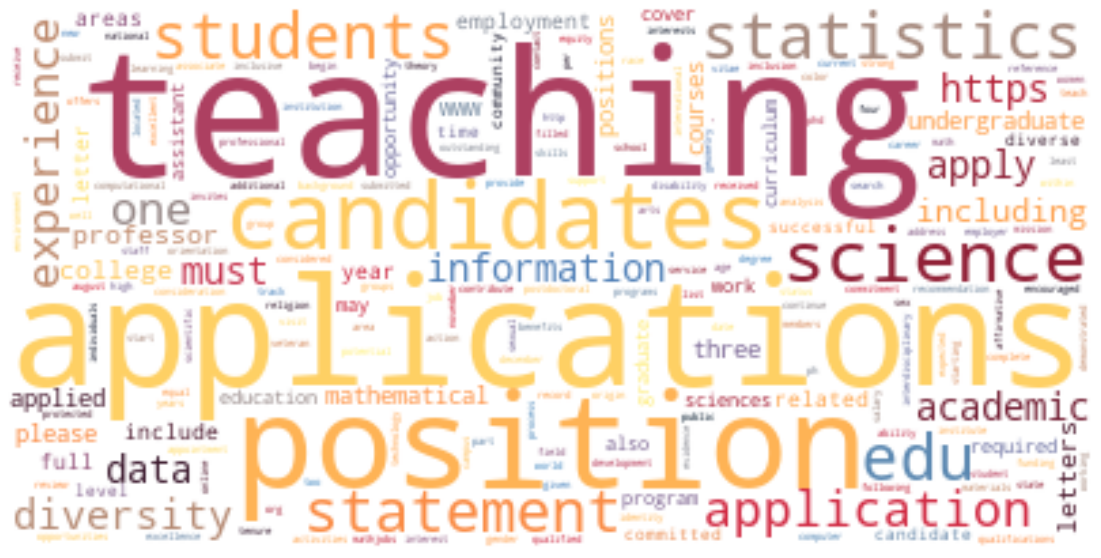

In [19]:
hero.visualization.wordcloud(data, font_path = None, width = 400, height = 200, max_words=200, 
                             mask=None, contour_width=0, 
                             contour_color='PAPAYAWHIP', background_color='WHITE', 
                             relative_scaling='auto', colormap=None, return_figure=False)

## Task 3: Tokenization, Lemmatization and Word Document Matrix

In [20]:
# Tokenize

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True ))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['baruch', 'college', 'cuny', 'invites', 'applications', 'two', 'anticipated', 'tenure', 'track', 'positions', 'beginning', 'august', 'appointment', 'assistant', 'professor', 'level', 'offers', 'undergraduate', 'majors', 'financial', 'actuarial', 'science', 'proposing', 'expand', 'computer', 'science', 'minor', 'major', 'graduate', 'level', 'offer', 'ms', 'degree', 'financial', 'engineering', 'baruch', 'one', 'city', 'new', 'york', 'senior', 'colleges', 'housing', 'zicklin', 'school', 'business', 'weissman', 'school', 'arts', 'sciences', 'marxe', 'school', 'public', 'international', 'affairs', 'undergraduate', 'graduate', 'students', 'three', 'schools', 'consider', 'applications', 'following', 'areas', 'computer', 'science', 'combinatorics', 'number', 'theory', 'partial', 'differential', 'equations', 'numerical', 'analysis', 'probability', 'stochastic', 'processes', 'statistics', 'focus', 'mathematical', 'foundations', 'data', 'science', 'actuarial', 'science', 'mathematical', 'financ

In [21]:
!python -m spacy download en

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[x] Couldn't link model to 'en'
Creating a symlink in spacy/data failed. Make sure you have the required
permissions and try re-running the command as admin, or use a virtualenv. You
can still import the model as a module and call its load() method, or create the
symlink manually.
C:\Users\krajarat\.conda\envs\mathjobs\lib\site-packages\en_core_web_sm -->
C:\Users\krajarat\.conda\envs\mathjobs\lib\site-packages\spacy\data\en
[!] Download successful but linking failed
Creating a shortcut link for 'en' didn't work (maybe you don't have admin
permissions?), but you can still load the model via its full package name: nlp =
spacy.load('en_core_web_sm')


You do not have sufficient privilege to perform this operation.


In [109]:
%%time
# Lemmatize

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adjective, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ']) #, 'VERB', 'ADV'

print(data_lemmatized[:2])

['application anticipated tenure track position appointment assistant professor level undergraduate major financial actuarial science computer science minor major graduate level m financial engineering baruch senior college art international affair graduate student school application area computer science combinatoric number theory partial differential equation numerical analysis probability stochastic process statistic mathematical science actuarial science mathematical finance qualification related area strong undergraduate teaching skill commitment compensation competitive compensation benefit package insurance pension retirement benefit parental saving program support scholarship publication part commitment ongoing professional development application online job cuny edu employment complete application mathjob sheet list publication letter address candidate short statement philosophy future plan addition statement commitment student multicultural multiethnic urban campus environmen

In [110]:
custom_stopwords = ["mathematics", "university", "research", "department", "application", "applicant", "candidate", "faculty",
                    "include", "position", "letter", "apply", "submit", "program", "area", "member", "require", "work",
                    'status', 'opportunity', 'start', 'demonstrate', 'equal', 'statement', 'employ', 'receive', 'year', 'include', 'information', 'gender', 'discriminate', 'discrimination', 'disability',
                    'veteran', 'indigenous', 'sexual', 'consider', 'diversity', 'protect', 'affirmative', 'race', 'orientation', 'appointment', 'must', 'date', 'negotiable',
                    'submit', 'available', 'good', 'inclusion', 'inclusive', 'also', 'may', 'job', 'career']
custom_stopwords = lemmatization([custom_stopwords], allowed_postags=['NOUN', 'ADJ'])[0].split(' ') #, 'VERB', 'ADV'
custom_stopwords = default_stopwords.union(custom_stopwords)

In [111]:
# Remove stop words again after lemmatization.
data_lemmatized = hero.remove_stopwords(pd.Series(data_lemmatized), custom_stopwords ).to_list()

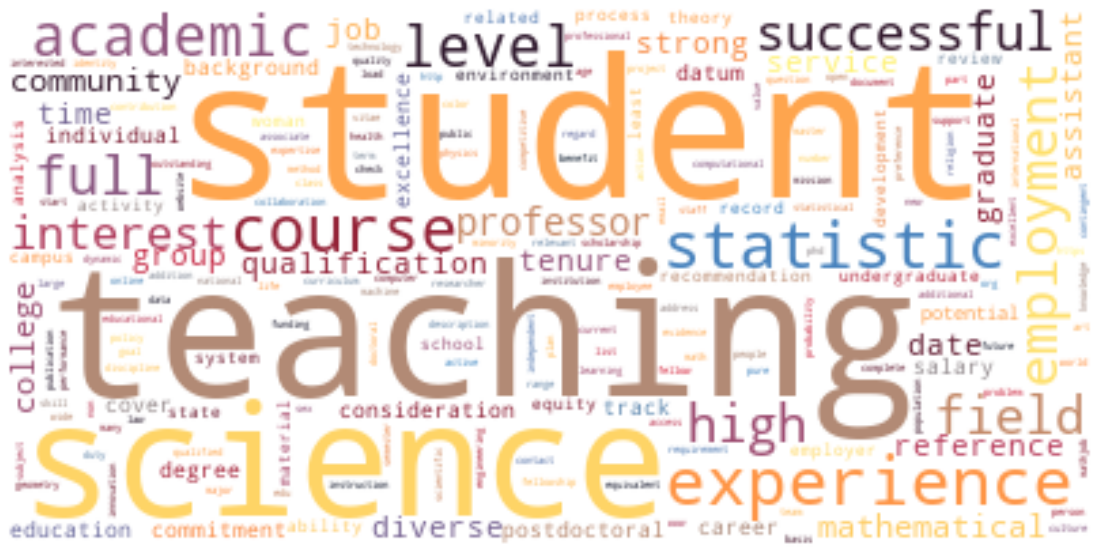

In [112]:
hero.visualization.wordcloud(pd.Series(data_lemmatized), font_path = None, width = 400, height = 200, max_words=200, 
                             mask=None, contour_width=0, 
                             contour_color='PAPAYAWHIP', background_color='WHITE', 
                             relative_scaling='auto', colormap=None, return_figure=False)

In [113]:
# Word-Document Matrix

vectorizer = CountVectorizer(ngram_range = (1,2),
                             analyzer='word',       
                             min_df=10,                        # minimum number occurences of a word required
                             max_df=0.80,
                             #stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}')  # num of characters > 3
                            
data_vectorized =  vectorizer.fit_transform(data_lemmatized)


## Task 4: Build LDA Model with Scikit Learn

In [123]:
%%time
# Build LDA model with Sklearn

lda_model = LatentDirichletAllocation(n_components=6,               # Number of topics
                                      max_iter=10,                   # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,              # Random state
                                      batch_size=128,                # n docs in each learning iter
                                      n_jobs=-1)
                                            
lda_output = lda_model.fit_transform(data_vectorized)                                      

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=6, n_jobs=-1,
                          random_state=100)
Wall time: 922 ms


In [124]:
#Evaluate model quality

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp((-1) * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))



Log Likelihood:  -345993.81568826415
Perplexity:  652.8505841098457


In [125]:
#Visualize with pyLDAvis

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\krajarat\.conda\envs\mathjobs\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2       1.465019 -47.625065       1        1  51.118833
4      54.854797 -36.476795       2        1  23.481367
5      32.212929 -61.444572       3        1  18.798535
3       5.111096 -14.110332       4        1   3.368925
1      26.350170 -33.374702       5        1   2.769603
0      38.109818  -7.222781       6        1   0.462738, topic_info=          Term        Freq       Total Category  logprob  loglift
529        job  218.000000  218.000000  Default  30.0000  30.0000
64   assistant  244.000000  244.000000  Default  29.0000  29.0000
891    science  675.000000  675.000000  Default  28.0000  28.0000
770  professor  266.000000  266.000000  Default  27.0000  27.0000
213     course  452.000000  452.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
243       date    1.290469  274.826573   Topic6  -5.2545   0.0146
763    process    1.189437  158.158455   Topic6  -5.3360   0.4856
213     course    1.348263  452.718380   Topic6  -5.2107  -0.4407
594   material    1.168039  160.086790   Topic6  -5.3542   0.4554
604    mathjob    1.107308  104.305891   Topic6  -5.4076   0.8304

[403 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2         1  0.449119  academic
2         2  0.364909  academic
2         3  0.098245  academic
2         4  0.047719  academic
2         5  0.039298  academic
...     ...       ...       ...
1116      4  0.504904   writing
1118      1  0.437670  www math
1118      2  0.328253  www math
1118      5  0.164126  www math
1118      6  0.054709  www math

[1076 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 6, 4, 2, 1])

## Task 5: Grid Search for Model Optimization

In [117]:
%%time
# Grid Search for Best LDA Model

from sklearn.model_selection import GridSearchCV

# Define Search Param
params = {"n_components" : [4, 5, 6, 7, 10, 15, 20, 25, 30]}

# Model
lda = LatentDirichletAllocation(random_state=100,
                                n_jobs=-1)

# Grid Search
model = GridSearchCV(lda, param_grid=params)

# Perform Grid Search
model.fit(data_vectorized)

Wall time: 23.4 s


GridSearchCV(estimator=LatentDirichletAllocation(n_jobs=-1, random_state=100),
             param_grid={'n_components': [4, 5, 6, 7, 10, 15, 20, 25, 30]})

In [118]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'n_components': 4}
Best Log Likelihood Score:  -75331.37124323235
Model Perplexity:  647.9963398015082


In [119]:
#Visualize with pyLDAvis

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\krajarat\.conda\envs\mathjobs\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      269.562408 -124.803398       1        1  33.709436
2        1.782994 -295.079681       2        1  31.407138
3      220.811432 -343.832123       3        1  27.033258
0       50.533993  -76.050934       4        1   7.850168, topic_info=            Term        Freq       Total Category  logprob  loglift
891      science  649.000000  649.000000  Default  30.0000  30.0000
984      student  753.000000  753.000000  Default  29.0000  29.0000
370   experience  536.000000  536.000000  Default  28.0000  28.0000
529          job  235.000000  235.000000  Default  27.0000  27.0000
141      college  272.000000  272.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1014    teaching   31.741011  664.761130   Topic4  -4.8830  -0.4972
984      student   32.425068  753.983852   Topic4  -4.8617  -0.6018
16      activity   24.185335  184.083793   Topic4  -5.1549   0.5150
999   successful   24.320167  290.188300   Topic4  -5.1493   0.0654
919      service   23.436137  246.638702   Topic4  -5.1863   0.1910

[317 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2         1  0.508780     academic
2         2  0.200264     academic
2         3  0.162377     academic
2         4  0.127195     academic
11        1  0.041768   accordance
...     ...       ...          ...
1115      3  0.093671       writer
1117      1  0.112317          www
1117      2  0.762154          www
1117      3  0.120340          www
1119      2  0.985139  www mathjob

[651 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

In [33]:
[token.lemma_ for token in nlp("data science")]

['datum', 'science']

In [34]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer,model=model,n_words=20):
  keywords = np.array(vectorizer.get_feature_names())
  topic_keywords = []
  for topic_weights in model.components_:
    topic_keyword_locs = (-topic_weights).argsort()[:n_words]
    topic_keywords.append(keywords.take(topic_keyword_locs))
  return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, model=best_lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords =  pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ["Word" + str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ["Topic" + str(i) for i in range(df_topic_keywords.shape[0])] 
df_topic_keywords

,Word0,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9
Topic0,student,teach,teaching,include,course,experience,undergraduate,graduate,college,statistic
Topic1,teach,status,teaching,opportunity,equal,statement,employment,receive,year,include
Topic2,year,include,postdoctoral,theory,start,fellowship,mathematical,date,salary,appointment
Topic3,science,statistic,datum,include,computer,experience,computational,develop,data,method


In [41]:
show_topics(vectorizer=vectorizer, model=best_lda_model, n_words=30)

[array(['student', 'teach', 'teaching', 'include', 'course', 'experience',
        'undergraduate', 'graduate', 'college', 'statistic', 'level',
        'diversity', 'community', 'academic', 'must', 'statement',
        'diverse', 'service', 'education', 'support', 'successful',
        'provide', 'information', 'qualification', 'tenure', 'commitment',
        'inclusion', 'professor', 'equity', 'address'], dtype='<U26'),
 array(['teach', 'status', 'teaching', 'opportunity', 'equal', 'statement',
        'employment', 'receive', 'year', 'include', 'information',
        'gender', 'disability', 'must', 'veteran', 'sexual',
        'equal opportunity', 'consideration', 'diversity', 'begin',
        'employer', 'protect', 'affirmative', 'affirmative action',
        'action', 'address', 'sexual orientation', 'race', 'orientation',
        'appointment'], dtype='<U26'),
 array(['year', 'include', 'postdoctoral', 'theory', 'start', 'fellowship',
        'mathematical', 'date', 'salary', 'ap

In [35]:
generated_topic_probabilities = best_lda_model.transform(data_vectorized)
generated_topics = np.argmax(generated_topic_probabilities, axis = 1)

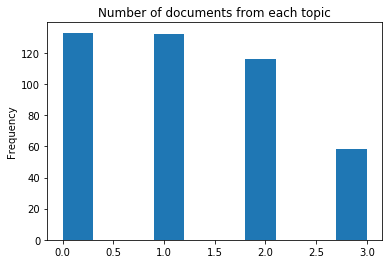

In [36]:
pd.Series(generated_topics).plot.hist(title="Number of documents from each topic")

In [37]:
df["Topic"] = generated_topics

In [38]:
df2 = df[['Title', 'Topic', 'Description', 'Creator', 'Country']][df['Topic'] ==0].sample(10)
df2

,Title,Topic,Description,Creator,Country
100,Instructor of Mathematics,0,Washington & Jefferson College (“W&J”) invi...,"Washington & Jefferson College, Mathematics",US
192,"Applied Algebra (broadly interpreted), Assista...",0,The Department of Mathematics in the Faculty o...,"University of Western Ontario, Department of M...",CA
264,"Probability, Assistant Professor in Probability",0,Assistant Professor in Probability\n\n De...,"Université de Montréal, Département de mathéma...",CA
78,Tenure stream positions - Mathematics,0,The University of Toronto invites applicati...,"University of Toronto, Mathematics",CA
50,Assistant Professor of Discrete Mathematics/Co...,0,Overview\n\n The Department of Mathematic...,"Utah State University, Department of Mathemati...",US
23,"Mathematics, Assistant Professor of Mathematics",0,Northern State University seeks a full-time te...,"Northern State University, College of Arts & S...",US
360,"Applied Mathematics, Assistant Professor of Ap...",0,The Department of Mathematical Sciences antici...,"United States Air Force Academy, Mathematical ...",US
157,"Data Science and Related Fields, Faculty",0,The Department of Applied Mathematics at Illin...,"Illinois Institute of Technology, Department o...",US
97,"Mathematics, Tenured/Tenure-track faculty posi...",0,The Faculty of Mathematics of the Pontifici...,"Pontificia Universidad CatÃ³lica de Chile, Dep...",CL
3,"Research, Postdoctoral Research Scholar",0,Postdoctoral Research Scholar Arizona State Un...,"Arizona State University, School of Mathematic...",US


In [39]:
df2.loc[426]['Title']

KeyError: 426

In [ ]:
df2.loc[252]['Description']

In [ ]:
df2 = df[['Title', 'Topic', 'Description', 'Creator', 'Country']][df['Topic'] == 1].sample(10)
df2

In [ ]:
df2.loc[13]['Description']

In [ ]:
df2 = df[['Title', 'Topic', 'Description', 'Creator', 'Country']][df['Topic'] == 3].sample(10)
df2

In [ ]:
generated_topic_probabilities[293]

In [ ]:
df2.loc[279]['Description']

In [ ]:
df.loc[35]['Description']

## Task 6: Gensim based model

In [ ]:
corpus_vect_gensim = gensim.matutils.Sparse2Corpus(data_vectorized, documents_columns=False)
id2word = dict((v,k) for k,v in vectorizer.vocabulary_.items())

In [ ]:
from gensim.models.ldamodel import LdaModel

# Train the model on the corpus. Use parameters we obtained from tuning the scikit-learn model.
lda = LdaModel(corpus_vect_gensim, 
               num_topics=model.best_params_['n_components'], 
               id2word=Dictionary.from_corpus(corpus_vect_gensim, id2word=id2word),
               decay = model.best_params_['learning_decay'], 
               random_state=100, update_every=1,
               chunksize=1500, 
               passes=5, iterations=10,
               alpha='asymmetric', eta=1/100,
               per_word_topics=True
              )

In [ ]:
# Show words from 
n_topics=5
n_top_words = 25
for index, topic in lda.show_topics(formatted=False, num_words= n_top_words):
        print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))

In [ ]:
lda?

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_vect_gensim, Dictionary.from_corpus(corpus_vect_gensim, id2word=id2word), mds='tsne')
panel

In [ ]:
LatentDirichletAllocation?

In [ ]:
LdaModel?